In [42]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
import ipynbname
from endaaman.ml import fix_global_seed

fix_global_seed()

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)


sns.set_theme(style='ticks', palette='tab10')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.dpi': 300,
})

os.makedirs('out/figs', exist_ok=True)


now working /home/ken/src/github.com/endaaman/bt


In [2]:
import random
import colorcet as cc

labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    r'VIT-L$\mathrm{_{IN}}$(FT)',
    r'VIT-L$\mathrm{_{IN}}$(LP)',
    r'VIT-L(RI)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    r'ResNet-RS 50(RI)',
]
print(len(labels))
# colors = sns.color_palette('pastel20', len(label))
colors = sns.color_palette(cc.glasbey_hv, n_colors=len(labels))
color_map = dict(zip(labels, colors))
display(colors)

11


[(0.18824, 0.63529, 0.85490),
 (0.98823, 0.30980, 0.18824),
 (0.89804, 0.68235, 0.21961),
 (0.42745, 0.56471, 0.30980),
 (0.54510, 0.54510, 0.54510),
 (0.09020, 0.74510, 0.81176),
 (0.58039, 0.40392, 0.74118),
 (0.83922, 0.15294, 0.15686),
 (0.12157, 0.46667, 0.70588),
 (0.89020, 0.46667, 0.76078),
 (0.54902, 0.33726, 0.29412)]

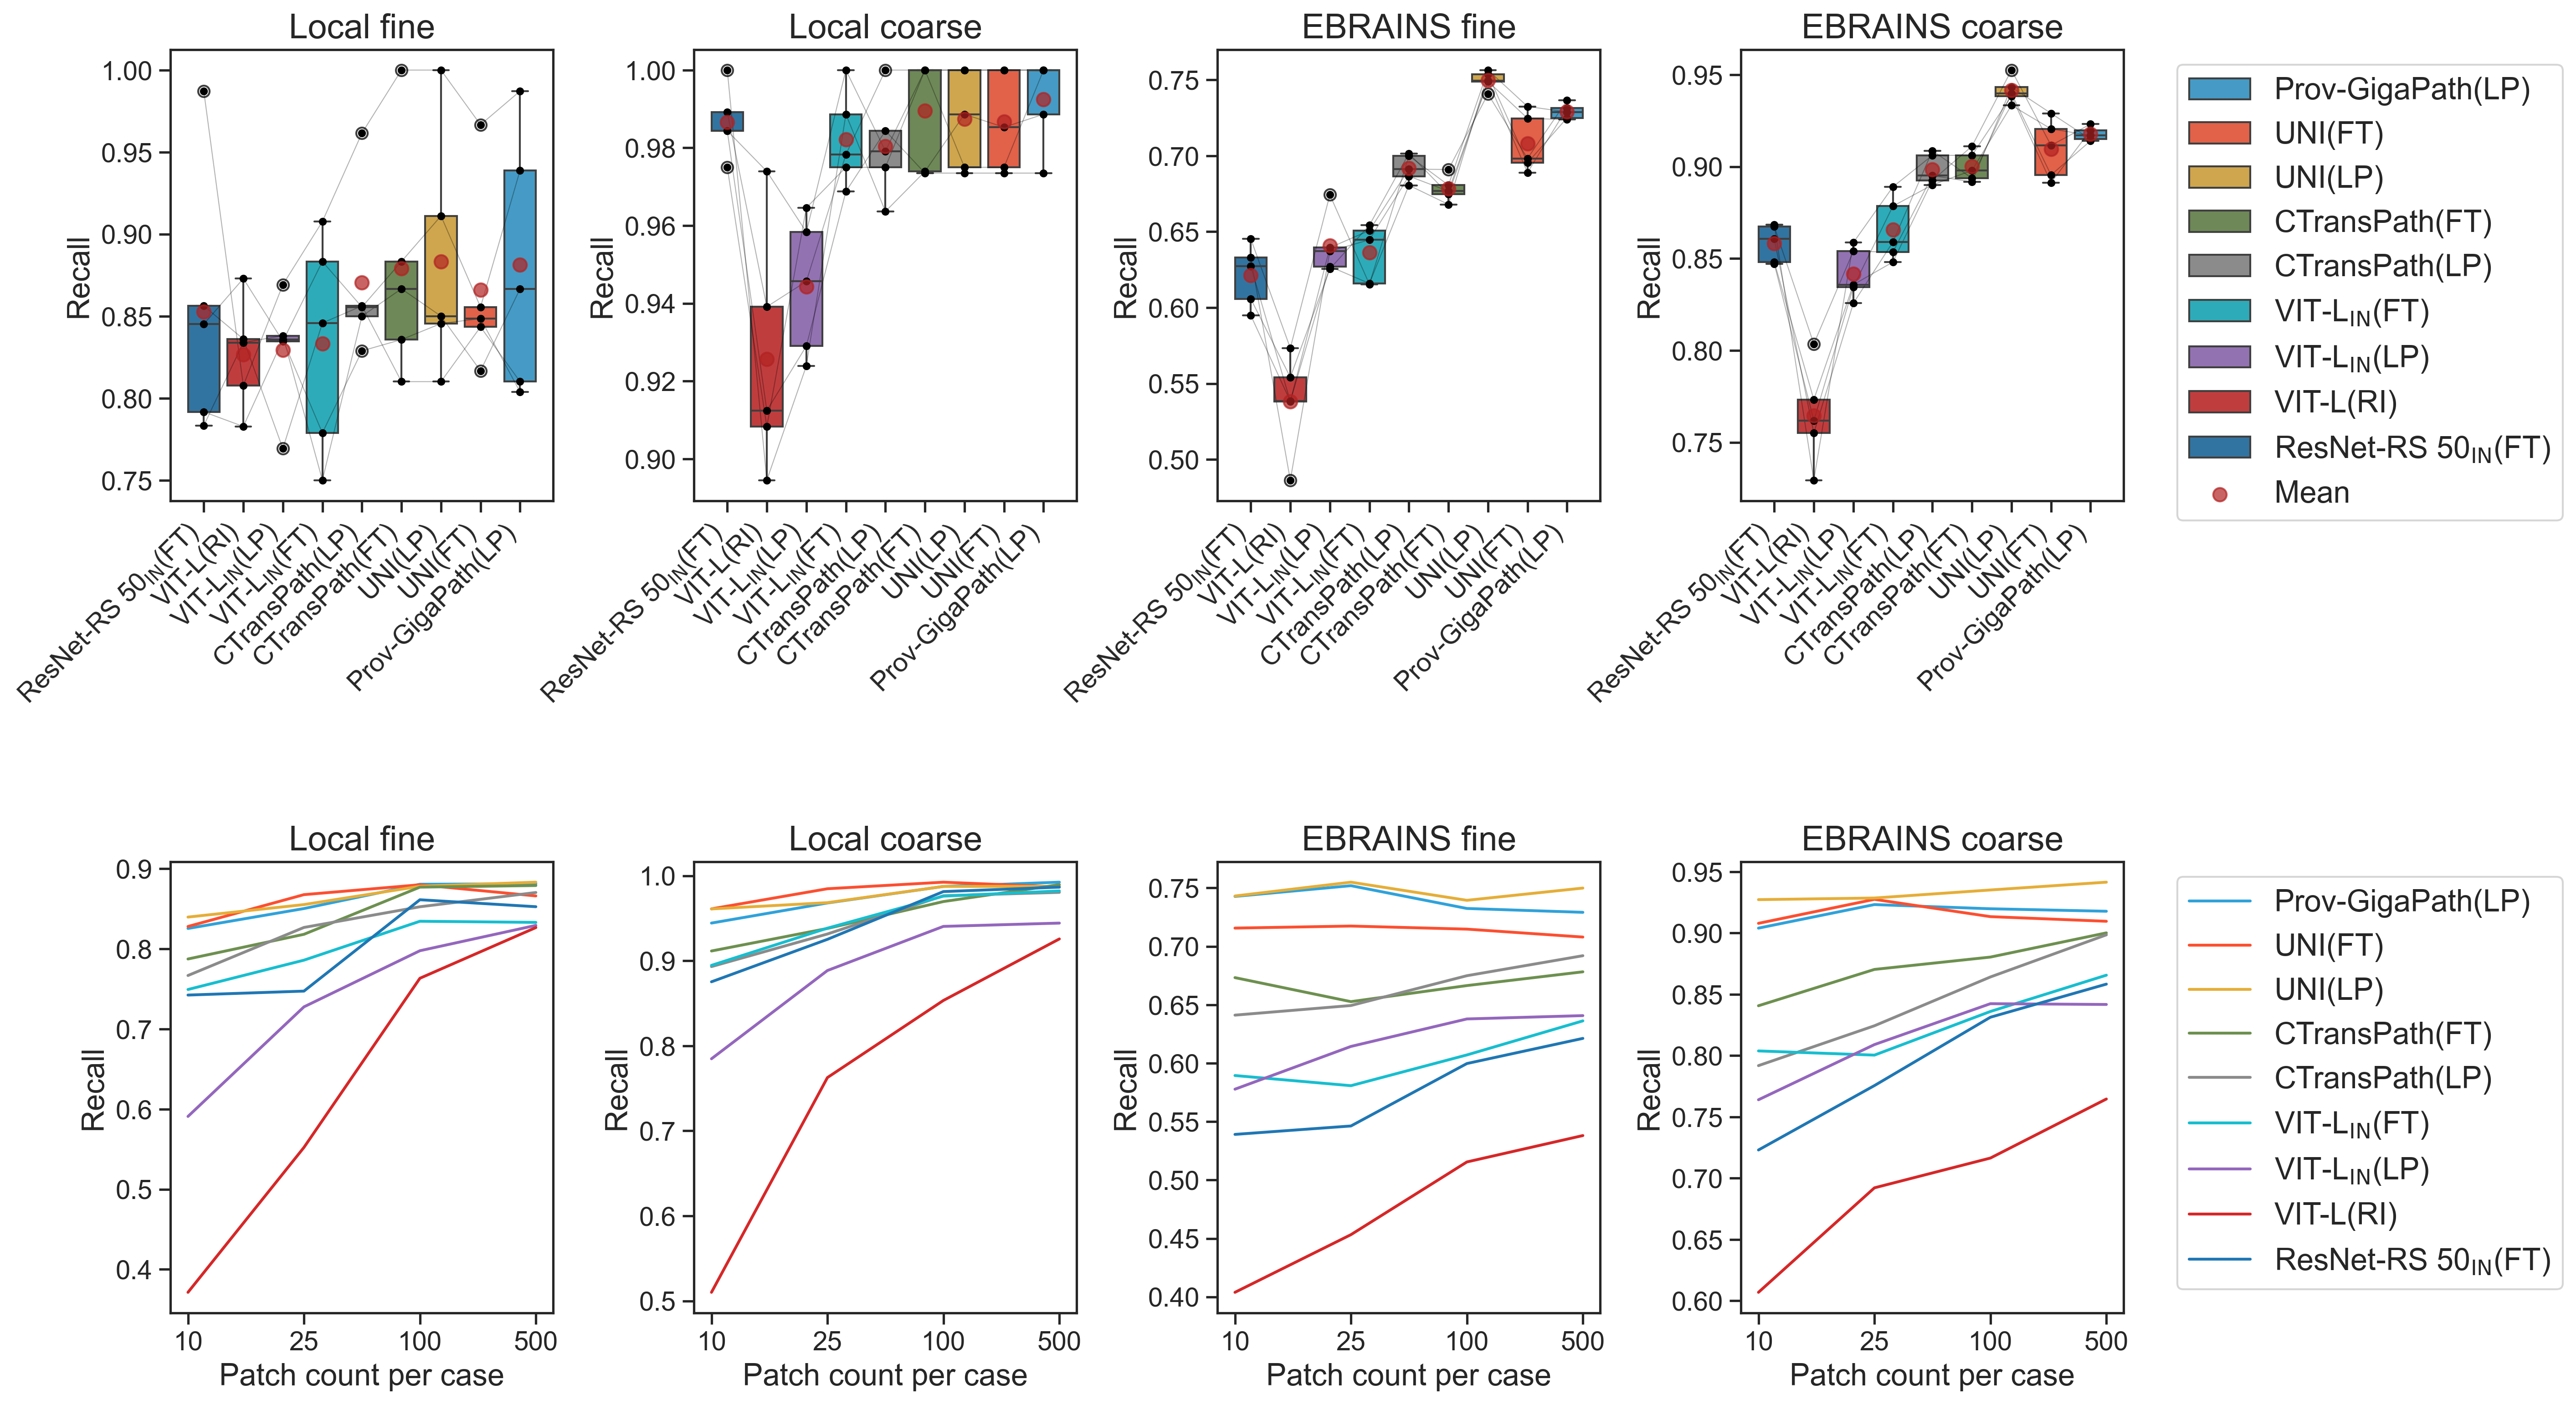

In [48]:
from matplotlib.gridspec import GridSpec

limit = 500

labels = [
    r'Prov-GigaPath(LP)',
    r'UNI(FT)',
    r'UNI(LP)',
    r'CTransPath(FT)',
    r'CTransPath(LP)',
    r'VIT-L$\mathrm{_{IN}}$(FT)',
    r'VIT-L$\mathrm{_{IN}}$(LP)',
    r'VIT-L(RI)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',    
]


key = 'recall'
recipes = [
    ['cv', 'fine'],
    ['cv', 'coarse'],
    ['ebrains', 'fine'],
    ['ebrains', 'coarse'],
]

key_map = {
    'pacc': 'Accuracy(Patch)',
    'recall': 'Recall',
    'acc': 'Accuracy',
    'f1': 'F1 score',
}


fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 5, width_ratios=[1, 1, 1, 1, 0.6],
    right = 0.95,
    left = 0.1,
    wspace = 0.4,
    hspace = 0.8,
)


axes = [
    fig.add_subplot(gs[0]),
    fig.add_subplot(gs[1]),
    fig.add_subplot(gs[2]),
    fig.add_subplot(gs[3]),
]

for i, ((target, grains), ax) in enumerate(zip(recipes, axes)):
    key_label = key_map[key]    
    df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)    
    df = df[df['label'].isin(labels)]

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key_label].mean().sort_values(ascending=True)
    df = df[::-1]    

    # Box plot
    sns.boxplot(x='label', 
                hue='label', 
                y=key_label, 
                data=df, 
                palette=[color_map[label] for label in labels[::-1]], 
                ax=ax, 
                legend=True if i == 3 else False)

    # Connect folds with lines
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax.plot(range(n_models), fold_data[key_label], 'k-', alpha=0.3, linewidth=0.5)
    
    # Scatter individual points
    for i, label in enumerate(labels[::-1]):
        ax.scatter([i] * n_folds, df[df['label'] == label][key_label], color='black', s=10, zorder=3)
    
    mean_scatter = ax.scatter(
        labels, 
        [df[df['label'] == l][key_label].mean() for l in labels],
        color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    # Set ax1 properties
    target_dataset = {
        'cv': 'Local',
        'ebrains': 'EBRAINS',
    }[target]
    ax.set_xticks(range(len(labels[::-1])))
    ax.set_xticklabels(labels[::-1], rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(key_label)
    ax.set_title(f'{target_dataset} {grains}')

box_handles = ax.get_legend_handles_labels()[0][:-1][::-1]
legend_handles = box_handles + [mean_scatter]
legend_labels = labels + ['Mean']
ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.1, 1), loc='upper left')


axes = [
    fig.add_subplot(gs[5]),
    fig.add_subplot(gs[6]),
    fig.add_subplot(gs[7]),
    fig.add_subplot(gs[8]),
]

for i, ((target, grains), ax) in enumerate(zip(recipes, axes)):
    key_label = {
        'pacc': 'Accuracy(Patch)',
        'recall': 'Recall',
        'acc': 'Accuracy',
        'f1': 'F1 score',
    }[key]
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

        for label in labels:
            scores = df[df['label']==label][key_label]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    x = np.arange(1, 1+len(limits))

    for i, label in enumerate(labels):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        # c = colors[i]
        c = color_map[label]
        ax.plot(x, values_by_cond[i, :, 0], color=c, label=label)
    
    ax.set_xticks(x, limits)
    ax.set_xlabel('Patch count per case')
    ax.set_ylabel(key_label)
    target_dataset = {
        'cv': 'Local',
        'ebrains': 'EBRAINS',
    }[target]
    ax.set_title(f'{target_dataset} {grains}')    

ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')



# plt.tight_layout()
plt.savefig('out/figs/fig2/fig2.png')
plt.show()
